<a href="https://www.kaggle.com/code/amolpathak/phone-price-range-amol-pathak?scriptVersionId=140838924" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-price-classification/train.csv
/kaggle/input/mobile-price-classification/test.csv


In [2]:
# Imports

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import shap

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Data Extraction

In [3]:
# Reading files
train_df = pd.read_csv('/kaggle/input/mobile-price-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/mobile-price-classification/test.csv')

## Data Analysis

In [4]:
# Printing the dimensions of dataset
print(f'train dataset dimensions: {train_df.shape}',f'\ntest dataset dimensions:{test_df.shape}')

train dataset dimensions: (2000, 21) 
test dataset dimensions:(1000, 21)


In [5]:
# Checking column names, data types and missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [6]:
# Separating X and y
y_train = train_df['price_range']
X_train = train_df.drop('price_range', axis=1)

In [7]:
# Checking the output label and counts
y_train.value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

In [8]:
# Separating different types of variables - Categorical and Continuous
categorical_vars = ['blue','dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
continuous_vars =  [i for i in list(X_train.columns) if i not in categorical_vars]

<Axes: >

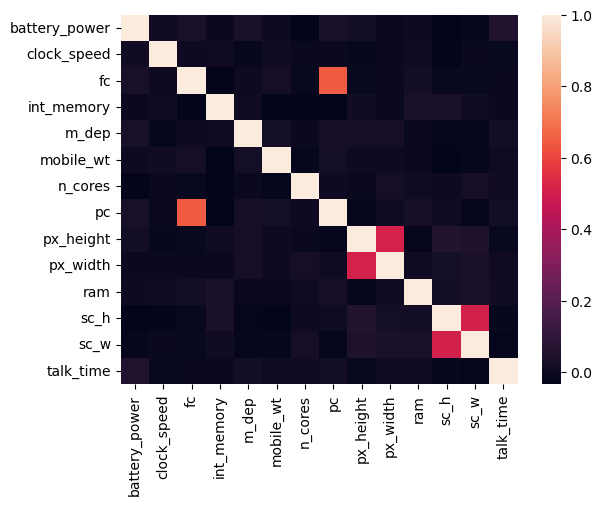

In [9]:
#Visualizing Correlation between continuous variables
corr = X_train[continuous_vars].corr()
sns.heatmap(corr)

There is a high correlation between:
- pc and fc: 0.644595 - Leave uncombined to check if there is a significant effect
- px_width and px_height: 0.510664 - Combine into product as megapixel
- screen_h and screen_w: 0.506144 - Combine into product as screen_size

## Data Transformation

#### Setting up a common data transform function

In [10]:
def transform_data(df, train_data=True):
    """
    Data transformation function
    """
    # Separating different types of variables - Categorical and Continuous
    if train_data:
        y = df['price_range']
        df = df.drop('price_range', axis=1)
    else:
        y = None
    
    df['megapixel'] = df['px_height'] * df['px_width']
    df['screensize'] = df['sc_h'] * df['sc_w']
    df = df.drop(['px_height','px_width','sc_h','sc_w'], axis = 1)
    
    return df, y

In [11]:
X_train, y_train  = transform_data(train_df)

In [12]:
continuous_vars =  [i for i in list(X_train.columns) if i not in categorical_vars]

In [13]:
# Setting scaler function
cont_var_df = X_train[continuous_vars]
scaler = StandardScaler().fit(cont_var_df)

#### Transforming Training Data

In [14]:
# Scaling continuous variables
scaled = scaler.transform(cont_var_df)
scaled_cont_var_df = pd.DataFrame(scaled, columns = continuous_vars)

# Merging to get final input dataframe
final_train_x_df = pd.concat([scaled_cont_var_df, X_train[categorical_vars]], axis=1)

In [15]:
final_train_x_df.head()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,megapixel,screensize,blue,dual_sim,four_g,three_g,touch_screen,wifi
0,-0.902597,0.830779,-0.762495,-1.380644,0.340740,1.349249,-1.101971,-1.305750,0.391703,1.462493,-1.073033,-0.224686,0,0,0,0,0,1
1,-0.495139,-1.253064,-0.992890,1.155024,0.687548,-0.120059,-0.664768,-0.645989,0.467317,-0.734267,1.077541,-0.380926,1,1,1,1,1,0
2,-1.537686,-1.253064,-0.532099,0.493546,1.381165,0.134244,0.209639,-0.645989,0.441498,-0.368140,1.521355,-0.758506,1,1,1,1,1,0
3,-1.419319,1.198517,-0.992890,-1.215274,1.034357,-0.261339,0.646842,-0.151168,0.594569,-0.002014,1.526741,0.621614,1,0,0,1,0,0
4,1.325906,-0.395011,2.002254,0.658915,0.340740,0.021220,-1.101971,0.673534,-0.657666,0.730240,0.673657,-0.836626,1,0,1,1,1,0


#### Transforming Test Data

In [16]:
X_transformed_test, y_test = transform_data(test_df, train_data=False)

In [17]:
# Scaling continuous variables
scaled = scaler.transform(X_transformed_test[continuous_vars])
scaled_cont_var_df = pd.DataFrame(scaled, columns = continuous_vars)

# Merging to get final input dataframe
final_test_x_df = pd.concat([scaled_cont_var_df, X_transformed_test[categorical_vars]], axis=1)

In [18]:
final_test_x_df.head()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,megapixel,screensize,blue,dual_sim,four_g,three_g,touch_screen,wifi
0,-0.445060,0.340463,2.232650,-1.490890,-1.393304,1.490528,-0.664768,1.003414,1.246506,-1.649584,-0.706581,0.048734,1,1,0,0,1,0
1,-0.904874,-1.253064,-0.071307,1.596010,1.034357,1.434017,0.209639,0.343653,1.632873,-0.734267,-0.320579,-1.044946,1,1,1,1,0,0
2,1.294038,1.566254,-0.762495,-0.278179,1.381165,1.292737,-0.664768,-0.975869,0.250619,-0.185077,1.000006,1.168453,1,0,0,0,1,1
3,0.699922,-1.253064,3.154233,-0.388426,-0.006069,-1.250297,1.521249,1.663176,1.631029,-0.734267,-0.468227,-1.044946,0,1,1,1,1,0
4,0.444976,-0.149853,1.541463,0.934531,-0.006069,-0.911225,0.646842,1.333295,-0.323860,-0.734267,-0.359916,0.517454,0,0,1,1,0,1


## Model Selection

#### Comparing models in sklearn for classification

LR: 0.928000 (0.016462)
LDA: 0.916000 (0.017436)
KNN: 0.595500 (0.038239)
CART: 0.848500 (0.021915)
NB: 0.805500 (0.020791)
SVM: 0.881500 (0.022366)


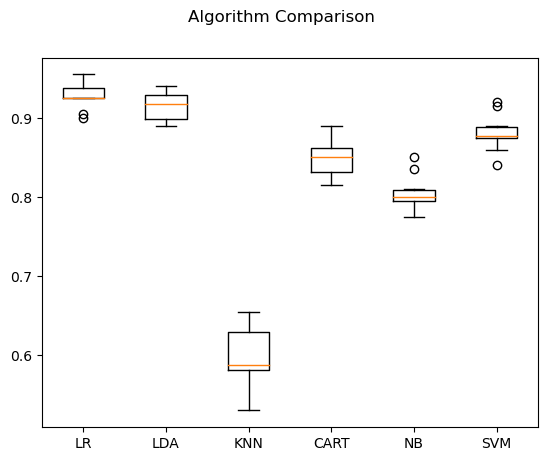

In [19]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
 kfold = StratifiedKFold(n_splits=10)
 cv_results = cross_val_score(model, final_train_x_df, y_train, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Building a Baseline Logistic Regression model to classify

In [20]:
# Using Stratified KFold Cross Validation to check model performance
l_model = LogisticRegression()
cv_results = cross_validate(l_model, final_train_x_df, y_train, cv=StratifiedKFold())

In [21]:
cv_results

{'fit_time': array([0.03021908, 0.02990389, 0.03088069, 0.03050113, 0.02936625]),
 'score_time': array([0.00242758, 0.00239515, 0.00242972, 0.00247979, 0.00240111]),
 'test_score': array([0.9325, 0.915 , 0.9225, 0.93  , 0.9275])}

In [22]:
# Printing model performance metrics
print(f"""Average accuracy = {round(np.mean(cv_results['test_score'])*100, 2)} %""")
print(f"""STD in accuracy = {round(np.std(cv_results['test_score'])*100, 2)} %""")

Average accuracy = 92.55 %
STD in accuracy = 0.62 %


This model gives a satisfactory output with about 92.5%

#### Trying other models

##### Decision Tree

In [23]:
dtree_classifier = DecisionTreeClassifier(criterion='gini')

In [24]:
# Using Stratified KFold Cross Validation to check model performance
cv_results = cross_validate(dtree_classifier, final_train_x_df, y_train, cv=StratifiedKFold())

In [25]:
# Printing model performance metrics
print(f"""Average accuracy = {round(np.mean(cv_results['test_score'])*100, 2)} %""")
print(f"""STD in accuracy = {round(np.std(cv_results['test_score'])*100, 2)} %""")

Average accuracy = 84.6 %
STD in accuracy = 1.07 %


In [26]:
dtree_classifier = dtree_classifier.fit(final_train_x_df, y_train)

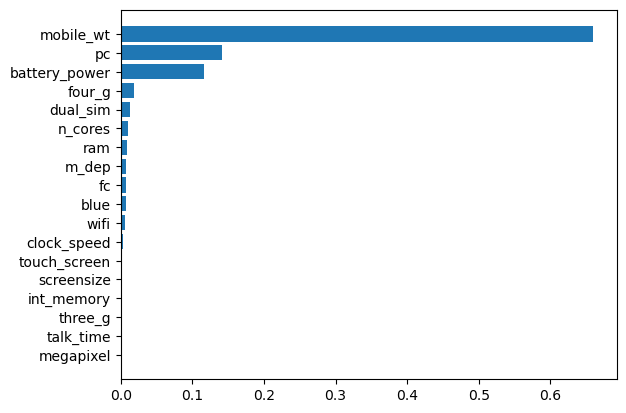

In [27]:
# Plotting the Variable according to their decreasing feature importance in tree
sorted_index = np.array(dtree_classifier.feature_importances_).argsort()
x_ax = X_train.columns[sorted_index]
y_ax = dtree_classifier.feature_importances_[sorted_index]
plt.barh(x_ax, y_ax)
plt.show()

Nonetheless, this model performs worse than the logistic regression model and hence can be ignored.

#### Xgboost

In [28]:
# Using Stratified KFold Cross Validation to check model performance
xgb_classifier = XGBClassifier()
cv_results = cross_validate(xgb_classifier, final_train_x_df, y_train, cv=StratifiedKFold())

In [29]:
# Printing model performance metrics
print(f"""Average accuracy = {round(np.mean(cv_results['test_score'])*100, 2)} %""")
print(f"""STD in accuracy = {round(np.std(cv_results['test_score'])*100, 2)} %""")

Average accuracy = 90.55 %
STD in accuracy = 1.1 %


In [30]:
# fit model on training data
xgb_classifier = xgb_classifier.fit(final_train_x_df, y_train)

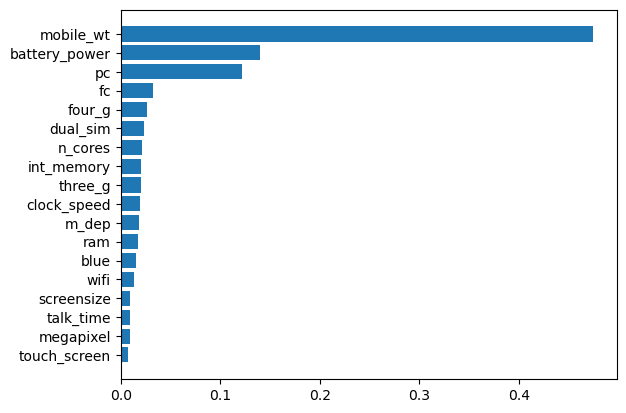

In [31]:
# Plotting the Variable according to their decreasing feature importance in tree
sorted_index = np.array(xgb_classifier.feature_importances_).argsort()
x_ax = X_train.columns[sorted_index]
y_ax = xgb_classifier.feature_importances_[sorted_index]
plt.barh(x_ax, y_ax)
plt.show()

#### Summary:
* Models Used:
1. Logistic Regression - Average accuracy = 92.55 % and STD in accuracy = 0.62 %
2. Decision Tree - Average accuracy = 84.05 % and STD in accuracy = 0.33 %
3. Xgboost Classifier - Average accuracy = 90.65 % and STD in accuracy = 1.37 %

#### Observation:
#### Logistic Regression still performs the best amongst all other models.

## Prediction

In [32]:
# Using the Logistic regression model to predict training 
clasifier = l_model.fit(final_train_x_df, y_train)
y_train_pred = l_model.predict(final_train_x_df)

In [33]:
def plot_conf_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix/np.sum(conf_matrix), fmt='.2%', annot=True, cmap='Blues')
    plt.show()
    return

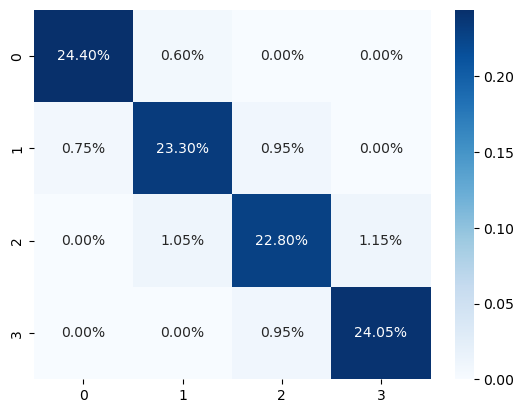

In [34]:
# Plotting confusion matrix to check where the errors are coming in from
plot_conf_matrix(y_train, y_train_pred)

#### Perforing prediction on test data

In [35]:
y_train_pred = l_model.predict(final_test_x_df)

In [36]:
y_train_pred[:5]

array([2, 3, 2, 3, 1])

## Using SHAP explainer for model explainability

In [37]:
# Fit the explainer
explainer = shap.Explainer(l_model.predict, final_train_x_df)
# Calculating the SHAP values - It takes some time
shap_values = explainer(final_train_x_df)

Permutation explainer: 2001it [01:06, 27.36it/s]                          


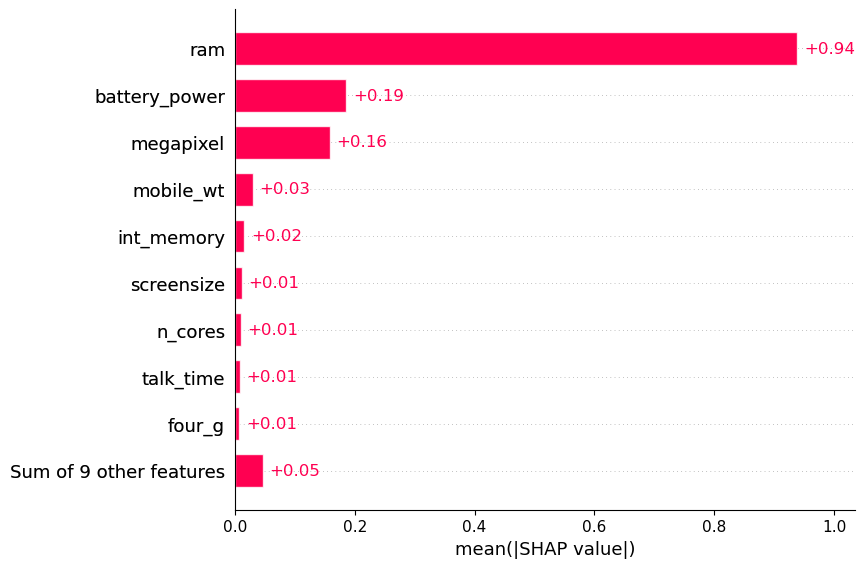

In [38]:
# Plotting average SHAP value for each variable
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


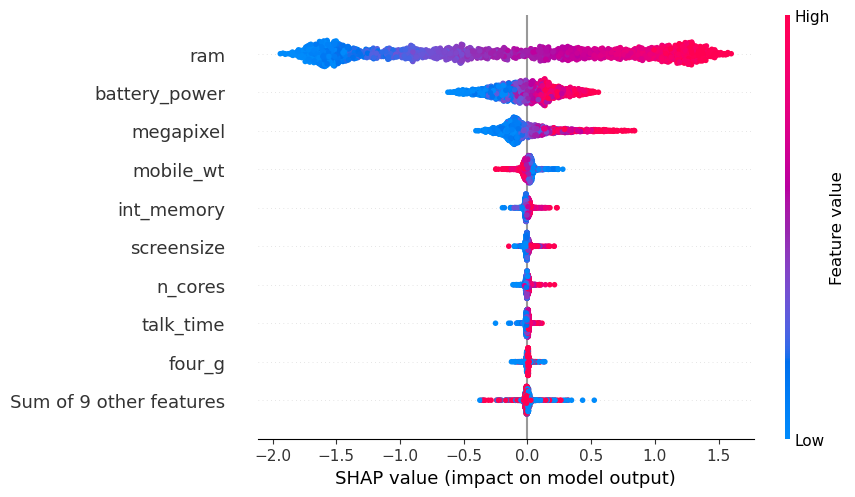

In [39]:
# Visualizing Summary of the model
shap.plots.beeswarm(shap_values)

In [40]:
# Checking the value of the first Prediction:
y_train_pred[0]

2

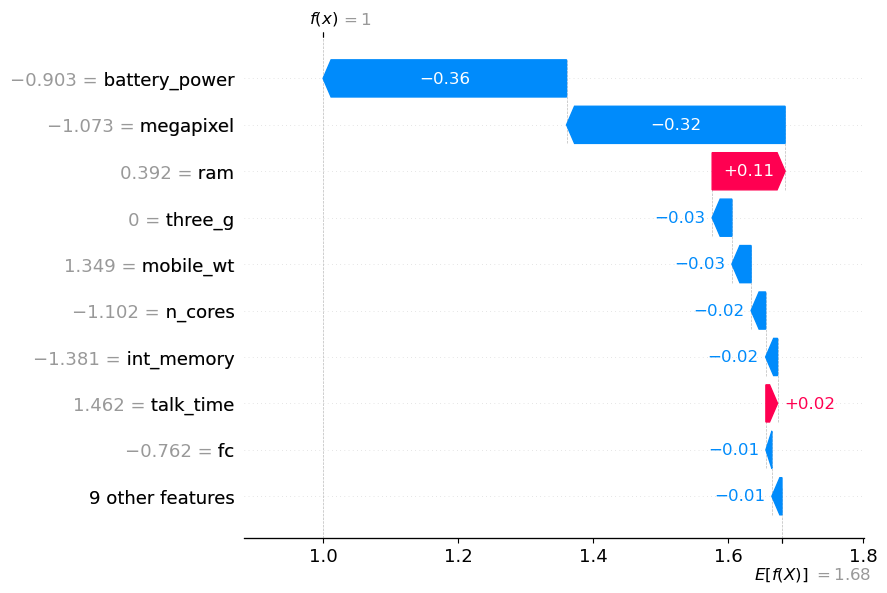

In [41]:
# Plotting Local Waterfall chart for this observation to check effect of each var
shap.plots.waterfall(shap_values[0])

#### Observations:
* RAM, Battery Power and megapixel are the main contributors in determining the price group.
* Higher price group had High RAM, Battery Power and MP.
* Higher price group had Low weight 